# Overview
This notebook contains the starter code for 11-411/11-611 Homework 3. It has minimal text so you can easily copy it to **handin.py** when you submit.  Please read all the comments in the code as there is important information in them.

In [2]:
#This code block has just standard setup code for running in Python
# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt

# Fix the random seed for reproducability
torch.random.manual_seed(8942764)
torch.cuda.manual_seed(8942764)
np.random.seed(8942764)

# Please set your device by uncommenting the right version below

# On colab or on a machine with access to an Nvidia GPU  use the following setting
#device = 'cuda:0'

# if you have an Apple Silicon machine with a GPU, use the following setting
# this should about 3-4 times faster that running it on a plain CPU
# device = 'mps'

# If you will use a cpu, this is the setting
device='cpu'

# note that in handin.py these next two steps would need to be removed
# if you are going run this on you personal machine these would need to be done
# in the shell/terminal to update your python libraries


In [3]:
!pip install transformers
!pip install datasets

from transformers import AutoTokenizer, BertModel
from datasets import load_dataset

### Load the dataset and pre-trained model from HuggingFace

In [4]:
# load the data set from the huggingface repositories

dataset = load_dataset("christinacdl/clickbait_notclickbait_dataset")
dataset


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 43802
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 2191
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8760
    })
})

In [5]:
# initialize pretrained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# if you want you can look at some sample  data items
print(dataset["train"][8])
print(dataset["validation"][6])
print(dataset["test"][0])

{'label': 1, 'text': '15 Things You Never Noticed About Owning A Cat'}
{'label': 1, 'text': 'It\'s Been 9 Years Since J.T. Died On "Degrassi" And We\'re Still Not Over It'}
{'label': 1, 'text': 'ABC News quiz: How much can you recall?'}


In [7]:
# This dataset has 3 splits, train, validation and test, and each has a  text  and label.

# Data from the dataset can generally be accessed like a Python dict.

# Print the original sentence.
print('Original: ', dataset['train'][8]['text'])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(dataset['train'][8]['text']))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(dataset['train'][8]['text'])))

Original:  15 Things You Never Noticed About Owning A Cat
Tokenized:  ['15', 'things', 'you', 'never', 'noticed', 'about', 'owning', 'a', 'cat']
Token IDs:  [2321, 2477, 2017, 2196, 4384, 2055, 19273, 1037, 4937]


In [ ]:
#code for tokenizing training data
def tokenize(batch):
  '''
  Transform the text under the 'sentence' key to
    batch has the following structure:
    [
      {
        k1: v1,
        k2: v2,
        ...
      },
      ...
    ]
  '''
  sentences = [x['text'] for x in batch]
  labels = torch.LongTensor([x['label'] for x in batch])
  new_batch = dict(tokenizer(sentences, padding=True, truncation=True, return_tensors="pt"))
  new_batch['label'] = labels
  return new_batch

### Record Training process

In [ ]:
def record_metrics(epoch, train_loss, val_loss, train_acc, val_acc, filename='/content/drive/MyDrive/Colab Notebooks/hw3-handout/log/log8.csv'):
    # Check if the log file already exists
    file_exists = os.path.isfile(filename)

    # Open the file in append mode; create it if it does not exist
    with open(filename, 'a', newline='') as f:
        writer = csv.writer(f)

        # If the file does not exist, write the header row first
        if not file_exists:
            writer.writerow(['epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

        # Write the current epoch's metrics to the file
        writer.writerow([epoch, train_loss, val_loss, train_acc, val_acc])

In [ ]:
def plot_log(file, save_plot_path):
  df = pd.read_csv(file)
  plt.figure(figsize=(10,6))
  plt.subplot(1,2,1)
  plt.plot(df['epoch'], df['train_loss'], label='train loss')
  plt.plot(df['epoch'], df['val_loss'], label='val loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(loc='best')
  plt.title('Loss')
  plt.subplot(1,2,2)
  plt.plot(df['epoch'], df['train_acc'], label='train acc')
  plt.plot(df['epoch'], df['val_acc'], label='val acc')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(loc='best')
  plt.title('Accuracy')
  save_plot = os.path.join(save_plot_path, (os.path.splitext(os.path.basename(file))[0]+'.png'))
  plt.savefig(save_plot)
  plt.show()

### Train and evaluate function

In [11]:
# This code evaluates a trained model on a dataset. It also uses  train() to train model
# You probably should not be making any changes to this code.
# During training, it will be printing some progress messages

@torch.no_grad()
def evaluate(model, dataset, batch_size, device, collate_fn=None):
  model = model.eval().to(device)
  dataloader = DataLoader(dataset, batch_size, shuffle=False, collate_fn=collate_fn)
  lossfn = nn.NLLLoss()

  loss_history = []
  acc_history = []
  for i, batch in enumerate(dataloader):
      batch = {k:v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
      y = batch.pop('label')

      logits = model(**batch)
      loss = lossfn(logits, y)

      pred = logits.argmax(1)
      acc = (pred == y).float().mean()
      loss_history.append(loss.item())
      acc_history.append(acc.item())

  return np.mean(loss_history), np.mean(acc_history), pred, y

def train(model,
          train_dataset,
          val_dataset,
          num_epochs,
          batch_size,
          optimizer_cls,
          lr,
          weight_decay,
          device,
          collate_fn=None):
  model = model.train().to(device)
  dataloader = DataLoader(train_dataset, batch_size, shuffle=True,
                          collate_fn=collate_fn)

  if optimizer_cls == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr, weight_decay=weight_decay)
  elif optimizer_cls == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

  train_loss_history = []
  train_acc_history = []
  val_loss_history = []
  val_acc_history = []
  best_val_loss = float('inf')

  lossfn = nn.NLLLoss()

  for e in range(num_epochs):
    epoch_loss_history = []
    epoch_acc_history = []
    for i, batch in enumerate(dataloader):
      batch = {k:v.to(device) for k,v in batch.items() if isinstance(v, torch.Tensor)}
      y = batch.pop('label')

      logits = model(**batch)
      loss = lossfn(logits, y)

      pred = logits.argmax(1)
      acc = (pred == y).float().mean()

      epoch_loss_history.append(loss.item())
      epoch_acc_history.append(acc.item())

      if (i % 100 == 0):
        print(f'epoch: {e}\t iter: {i}\t train_loss: {np.mean(epoch_loss_history):.3e}\t train_accuracy:{np.mean(epoch_acc_history):.3f}')
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    val_loss, val_acc, _, _ = evaluate(model, val_dataset, batch_size, device, collate_fn=collate_fn)

    # Save the model
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_model_path = os.path.join(os.getcwd(), '/content/drive/MyDrive/Colab Notebooks/hw3-handout/model/model8.pt')
      torch.save(model.state_dict(),save_model_path)
      print(f"Model saved at {e} epoch")

    train_loss_history.append(np.mean(epoch_loss_history))
    train_acc_history.append(np.mean(epoch_acc_history))
    val_loss_history.append(val_loss.item())
    val_acc_history.append(val_acc.item())
    print(f'epoch: {e}\t train_loss: {train_loss_history[-1]:.3e}\t train_accuracy:{train_acc_history[-1]:.3f}\t val_loss: {val_loss_history[-1]:.3e}\t val_accuracy:{val_acc_history[-1]:.3f}')
    record_metrics(e, train_loss_history[-1], val_loss_history[-1], train_acc_history[-1], val_acc_history[-1])

  return model, (train_loss_history, train_acc_history, val_loss_history, val_acc_history)


### Build BERT model

In [12]:
# This code defines the test classification class using BERT.
# The classifier is defined on top of the final layer of BERT.
# The classifier has 1 hidden layer with 128 hidden nodes though we have found that
# using a smaller number of hidden nodes does not make much difference,

class BertForTextClassification(nn.Module):
  def __init__(self, bert_pretrained_config_name, num_classes, freeze_bert=False):
    '''
    BeRT with a classification MLP
    args:
    - bert_pretrained_config_name (str): model name from huggingface hub
    - num_classes (int): number of classes in the classification task
    - freeze_bert (bool): [default False] If true gradients are not computed for
                          BeRT's parameters.
    '''
    super().__init__()
    self.bert = BertModel.from_pretrained(bert_pretrained_config_name)
    self.bert.requires_grad_(not freeze_bert)
    self.classifier = nn.Sequential(
        nn.Linear(self.bert.config.hidden_size, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, num_classes),
        nn.LogSoftmax(dim=-1)
    )


  def forward(self, **bert_kwargs):
     output=self.bert(**bert_kwargs)
     cls_embed = output.pooler_output
     logits = self.classifier(cls_embed)
     return logits

### Error Analysis

In [36]:
def evaluate_val(model, dataset, batch_size, device, collate_fn=None):
    # Set the model to evaluation mode and move it to the specified device
    model = model.eval().to(device)
    dataloader = DataLoader(dataset, batch_size, shuffle=False, collate_fn=collate_fn)

    lossfn = nn.NLLLoss()
    loss_history = []
    acc_history = []

    # Dictionary to categorize results into True Positives (TP), True Negatives (TN),
    # False Positives (FP), and False Negatives (FN) for further analysis
    validation_results = {'TP': [], 'TN': [], 'FP': [], 'FN': []}

    # Disable gradient calculation for evaluation to save memory and computation
    with torch.no_grad():
      # Iterate through each batch in the dataloader
      for i, batch in enumerate(dataloader):
          # Move each tensor in the batch to the device
          batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

          y = batch.pop('label')
          logits = model(**batch)
          loss = lossfn(logits, y)
          pred = logits.argmax(1)
          # Calculate batch accuracy and add the loss and accuracy values to history lists
          acc = (pred == y).float().mean()
          loss_history.append(loss.item())
          acc_history.append(acc.item())

          # Categorize each prediction as TP, TN, FP, or FN
          for i in range(len(y)):
              # Get the actual label and predicted label for the i-th sample in the batch
              true_label = y[i].item()
              pred_label = pred[i].item()

              # Retrieve the input IDs for further analysis (e.g., text data associated with predictions)
              input_ids = batch['input_ids'][i]  # Assumes 'input_ids' is a key in the batch

              # Categorize the predictions based on the true and predicted labels
              if pred_label == 1 and true_label == 1:
                  validation_results['TP'].append((input_ids, logits[i]))  # True Positive
              elif pred_label == 0 and true_label == 0:
                  validation_results['TN'].append((input_ids, logits[i]))  # True Negative
              elif pred_label == 1 and true_label == 0:
                  validation_results['FP'].append((input_ids, logits[i]))  # False Positive
              elif pred_label == 0 and true_label == 1:
                  validation_results['FN'].append((input_ids, logits[i]))  # False Negative

    # Return the dictionary with categorized predictions for TP, TN, FP, and FN
    return validation_results


In [24]:
def get_logits_and_probabilities(model, samples, device):
    # Set the model to evaluation mode (disables dropout layers, etc.)
    model.eval().to(device)

    # Tokenize the input samples and move them to the specified device (e.g., GPU)
    inputs = tokenizer(samples, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
      # Obtain log probabilities from the model directly (assumes model outputs log-probs)
      log_probs = model(**inputs)  # Directly get log probabilities

    # Convert log probabilities to regular probabilities for further analysis
    probabilities = log_probs.exp()  # Exponential to get back to probability space

    # Convert probabilities back to logits (log-odds ratio) for comparison
    logits = torch.log(probabilities / probabilities.sum(dim=-1, keepdim=True))  # Revert to logits

    # Detach tensors and move to CPU for numpy conversion (for easy manipulation and visualization)
    return logits.detach().cpu().numpy(), log_probs.detach().cpu().numpy()

In [44]:
def plot_metrics(metrics_dict, save_plot_path):
    # Set up the figure with a defined size for subplots
    plt.figure(figsize=(14, 6))

    # Colors and labels for each category
    categories = {
        'TP': ('green', 'o'),  # True Positives: green circles
        'FP': ('red', 'o'),    # False Positives: red triangles
        'TN': ('blue', 'o'),   # True Negatives: blue squares
        'FN': ('orange', 'o')  # False Negatives: orange x-marks
    }

    # Plot logits (log-odds) for the two classes (subplot 1)
    plt.subplot(1, 2, 1)
    for category, (color, marker) in categories.items():
        if category in metrics_dict:
            logits = metrics_dict[category]['logits']
            plt.scatter(logits[:, 0], logits[:, 1], color=color, marker=marker, label=category)
    plt.title('Logits')
    plt.xlabel('Logit 1')
    plt.ylabel('Logit 2')
    plt.legend()  # Add a legend for distinguishing the categories

    # Plot log probabilities for the two classes (subplot 2)
    plt.subplot(1, 2, 2)
    for category, (color, marker) in categories.items():
        if category in metrics_dict:
            log_probs = metrics_dict[category]['log_probs']
            plt.scatter(log_probs[:, 0], log_probs[:, 1], color=color, marker=marker, label=category)
    plt.title('Log Probabilities')
    plt.xlabel('Log Probability 1')
    plt.ylabel('Log Probability 2')
    plt.legend()  # Add a legend for distinguishing the categories

    # Save the plot to the specified path with a descriptive name
    save_plot = os.path.join(save_plot_path, 'logits_and_log_probabilities')
    plt.savefig(save_plot)

    # Display the plot in the notebook
    plt.show()


### Train

In [ ]:
# This is where fine-tuning of the classifier happens.
# Here we are training with batch size 32 for 5 epochs.
# At the end of each batch you see the training loss and training accuracy.

# Using a larger batch-size may cause memory issues with the GPU so we suggest you do not increase it.

# At the end of each epoch, you also see validation loss and validation accuracy.
# Change the device as described above if you will not be using a GPU

# If you run this block multiple times for some reason, uncomment the following lines to set
# the random seed for reproducability

#torch.random.manual_seed(8942764)
#torch.cuda.manual_seed(8942764)
#np.random.seed(8942764)

bert_cls = BertForTextClassification('bert-base-uncased', 2, freeze_bert=True)

print(f'num_trainable_params={sum([p.numel() for p in bert_cls.parameters() if p.requires_grad])}\n')

bert_cls, bert_cls_logs = train(bert_cls, dataset['train'], dataset['validation'],
                                num_epochs=15, batch_size=64, optimizer_cls='SGD',
                                lr=1e-3, weight_decay=1e-3, device=device,
                                collate_fn=tokenize)

# this is where you run the test data (from huggingface) over the trained model and compute test loss and test accuracy
print('\n')
print('Starting test run')
test_loss, test_acc, _, _=evaluate(bert_cls,dataset['test'],batch_size=64, device=device, collate_fn=tokenize)
print(f'Test Complete.\t Test Loss: {test_loss:.3e}\t Test Accuracy: {test_acc:.3f}')


num_trainable_params=51362



KeyboardInterrupt: 

### Result

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# Initialize a BERT-based model for text classification with 2 output classes
# 'bert-base-uncased' is a pre-trained BERT model; freeze_bert=True means the BERT layers will not be fine-tuned
model = BertForTextClassification('bert-base-uncased', 2, freeze_bert=True)

# Load the saved model parameters from a specified file path and set it to the CPU if needed
# map_location=torch.device('cpu') ensures compatibility if the model was saved on a different device (e.g., GPU)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/hw3-handout/model/model5.pt', map_location=torch.device('cpu')))

# Move the model to the specified device (GPU or CPU) for evaluation
model.to(device)

# Generate predictions for the validation set using the trained model
model.eval()  # Set the model to evaluation mode

# Call the evalute_val function to generate the validation_results
validation_results = evaluate_val(model, dataset['validation'], batch_size=64, device=device, collate_fn=tokenize)



<ipython-input-37-f18012664073>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/hw3-handout/model/m

串流輸出內容已截斷至最後 5000 行。
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,

In [38]:
print(len(validation_results))

4


In [39]:
for keys in validation_results.keys():
  print(f"{keys}: {len(validation_results[keys])}")

TP: 667
TN: 1281
FP: 97
FN: 146


TP samples: 20
FP samples: 20
TN samples: 20
FN samples: 20


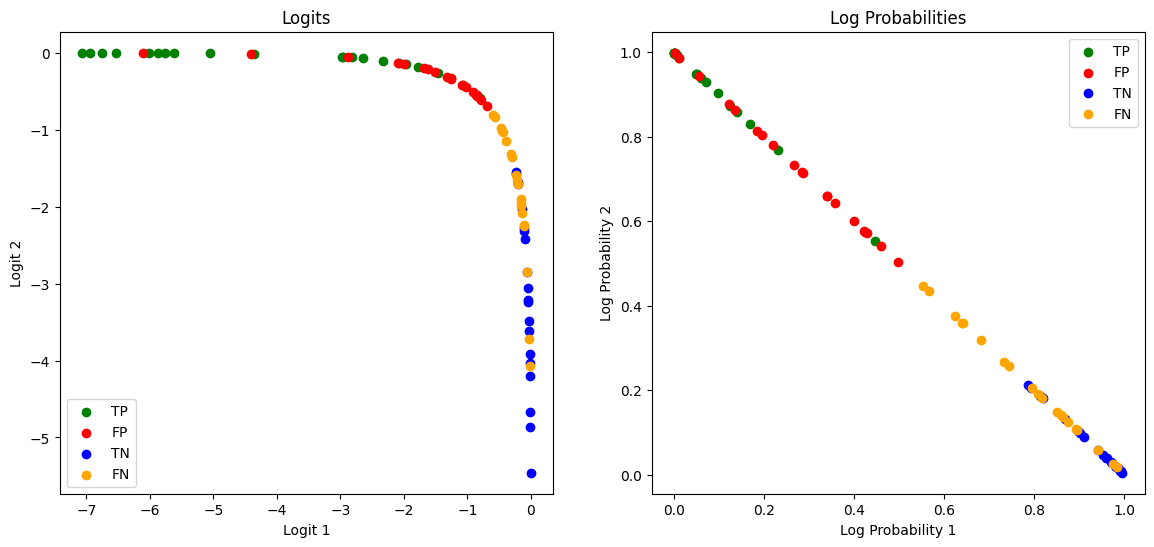

In [45]:
import random

# Randomly sample up to 20 items from each category
validation_results_20 = {
    'TP': random.sample(validation_results['TP'], min(20, len(validation_results['TP']))),
    'TN': random.sample(validation_results['TN'], min(20, len(validation_results['TN']))),
    'FP': random.sample(validation_results['FP'], min(20, len(validation_results['FP']))),
    'FN': random.sample(validation_results['FN'], min(20, len(validation_results['FN'])))
}

# Decode input IDs for each category
tp = [tokenizer.decode(items[0], skip_special_tokens=True) for items in validation_results_20['TP']]
fp = [tokenizer.decode(items[0], skip_special_tokens=True) for items in validation_results_20['FP']]
tn = [tokenizer.decode(items[0], skip_special_tokens=True) for items in validation_results_20['TN']]
fn = [tokenizer.decode(items[0], skip_special_tokens=True) for items in validation_results_20['FN']]

# Print lengths for verification
print("TP samples:", len(tp))
print("FP samples:", len(fp))
print("TN samples:", len(tn))
print("FN samples:", len(fn))

# Compute logits and probabilities for each category
logits_tp, probs_tp = get_logits_and_probabilities(model, tp, device)
logits_fp, probs_fp = get_logits_and_probabilities(model, fp, device)
logits_tn, probs_tn = get_logits_and_probabilities(model, tn, device)
logits_fn, probs_fn = get_logits_and_probabilities(model, fn, device)

# Create a metrics dictionary for plotting
metrics_dict = {
    'TP': {'logits': logits_tp, 'log_probs': probs_tp},
    'FP': {'logits': logits_fp, 'log_probs': probs_fp},
    'TN': {'logits': logits_tn, 'log_probs': probs_tn},
    'FN': {'logits': logits_fn, 'log_probs': probs_fn}
}

# Define the file path where the metric plots (logits and probabilities) will be saved
save_plot_path = '/content/drive/MyDrive/Colab Notebooks/hw3-handout/metrics'

# Generate and save plots of the logits and log probabilities for analysis
plot_metrics(metrics_dict, save_plot_path)



#### Print out the sentence for each situation

In [49]:
for sample in tp:
    tokens = tokenizer.tokenize(sample)
    print(f"TP Sample: {sample}")
    print(f"Tokenized: {tokens}\n")

for sample in tn:
    tokens = tokenizer.tokenize(sample)
    print(f"TN Sample: {sample}")
    print(f"Tokenized: {tokens}\n")

for sample in fp:
    tokens = tokenizer.tokenize(sample)
    print(f"FP Sample: {sample}")
    print(f"Tokenized: {tokens}\n")

for sample in fn:
    tokens = tokenizer.tokenize(sample)
    print(f"FN Sample: {sample}")
    print(f"Tokenized: {tokens}\n")

TP Sample: the 27 most important things cats did on the internet in 2015
Tokenized: ['the', '27', 'most', 'important', 'things', 'cats', 'did', 'on', 'the', 'internet', 'in', '2015']

TP Sample: we tried animal balls, brains, udders, and tongues
Tokenized: ['we', 'tried', 'animal', 'balls', ',', 'brains', ',', 'ud', '##ders', ',', 'and', 'tongues']

TP Sample: this may be the first couple to have an official wedding hashtag
Tokenized: ['this', 'may', 'be', 'the', 'first', 'couple', 'to', 'have', 'an', 'official', 'wedding', 'hash', '##tag']

TP Sample: who would you end up with in " once upon a time " based on your zodiac sign
Tokenized: ['who', 'would', 'you', 'end', 'up', 'with', 'in', '"', 'once', 'upon', 'a', 'time', '"', 'based', 'on', 'your', 'zodiac', 'sign']

TP Sample: do you know these classic " star wars " characters
Tokenized: ['do', 'you', 'know', 'these', 'classic', '"', 'star', 'wars', '"', 'characters']

TP Sample: michael b. jordan was gorgeous and perfect at the golde

### Loss and Accuracy plot

#### Setting1:
1.   Epoch: 5
2.   Batch size: 32
3.   Learning rate: 0.001
4.   Optimizer: Adam
5.   Weight decay = 1e-4
6.   Hidden layers: (128,num_class)



In [ ]:
save_plot_path = '/content/drive/MyDrive/Colab Notebooks/hw3-handout/log_plot'

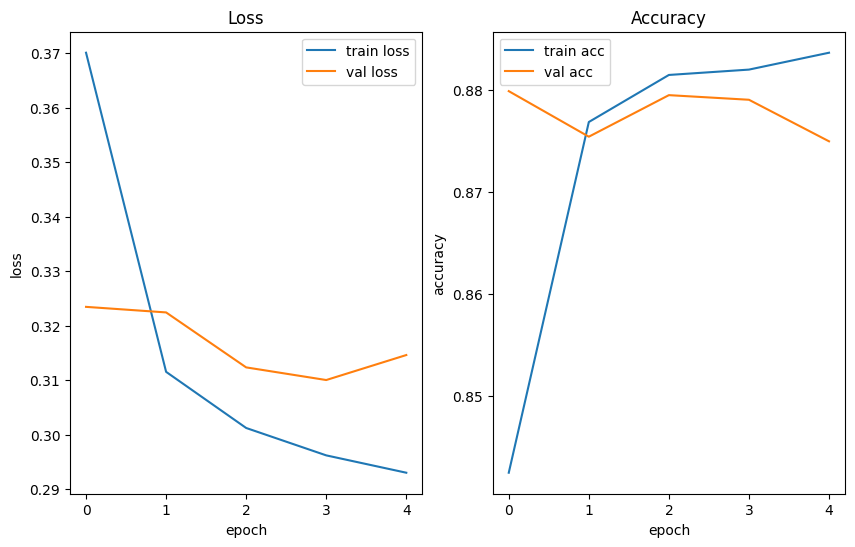

In [ ]:
plot_log('/content/drive/MyDrive/Colab Notebooks/hw3-handout/log/log.csv', save_plot_path)

#### Setting2:
1.   Epoch: 5
2.   Batch size: 32
3.   Learning rate: 0.001
4.   Optimizer: SGD
5.   Weight decay = 1e-4
6.   Hidden layers: (128,num_class)


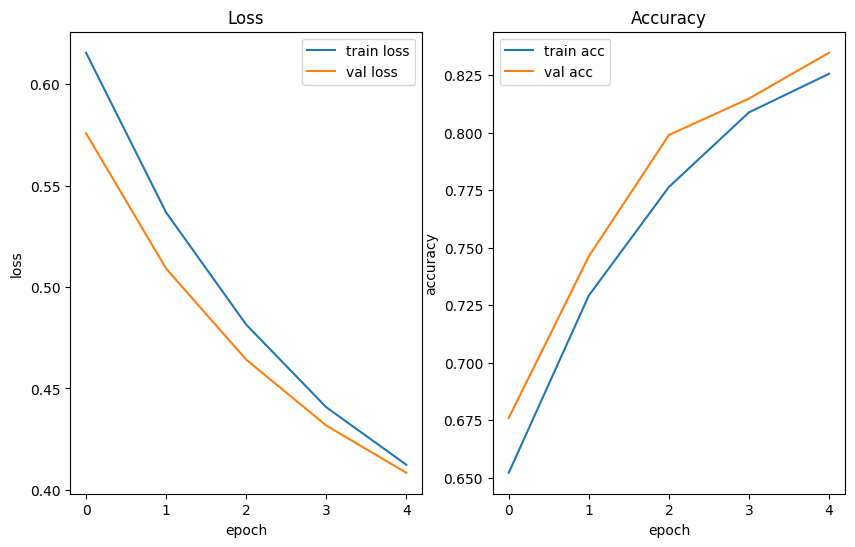

In [ ]:
plot_log('/content/drive/MyDrive/Colab Notebooks/hw3-handout/log/log2.csv', save_plot_path)

#### Setting3:
1.   Epoch: 10
2.   Batch size: 64
3.   Learning rate: 0.001
4.   Optimizer: Adam
5.   Weight decay = 1e-4
6.   Hidden layers: (128,num_class)



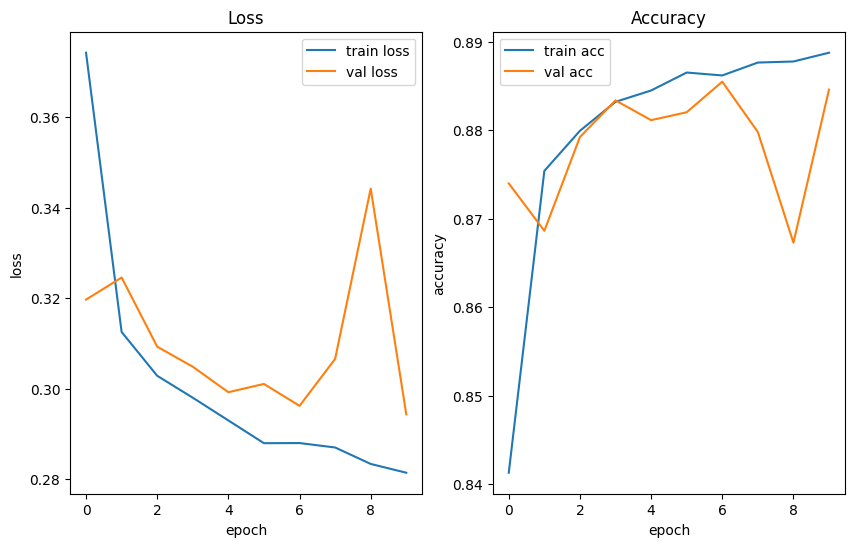

In [ ]:
plot_log('/content/drive/MyDrive/Colab Notebooks/hw3-handout/log/log3.csv', save_plot_path)

#### Setting4:
1.   Epoch: 10
2.   Batch size: 64
3.   Learning rate: 0.001
4.   Optimizer: Adam
5.   Weight decay = 1e-4
6.   Hidden layers: (128,64) (64,num_class)


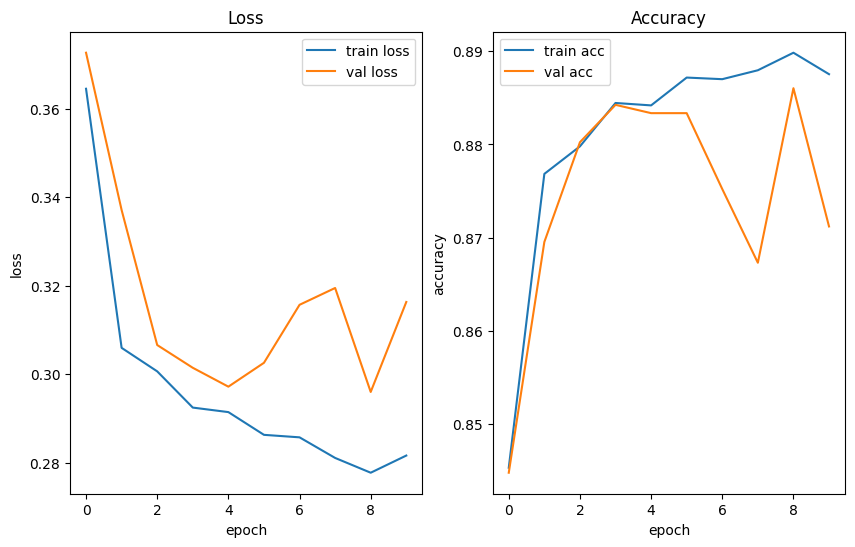

In [ ]:
plot_log('/content/drive/MyDrive/Colab Notebooks/hw3-handout/log/log4.csv', save_plot_path)

#### Setting5:
1.   Epoch: 15
2.   Batch size: 64
3.   Learning rate: 0.001
4.   Optimizer: Adam
5.   Weight decay = 1e-4
6.   Hidden layers: (64,32) (32,num_class)

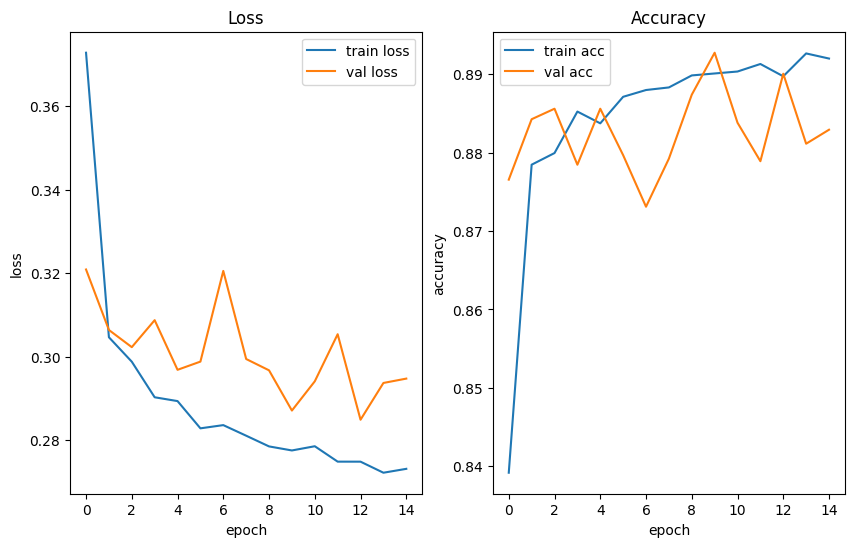

In [ ]:
plot_log('/content/drive/MyDrive/Colab Notebooks/hw3-handout/log/log5.csv', save_plot_path)

#### Setting6:
1.   Epoch: 5
2.   Batch size: 16
3.   Learning rate: 0.001
4.   Optimizer: Adam
5.   Weight decay = 1e-4
6.   Hidden layers: (128,num_class)

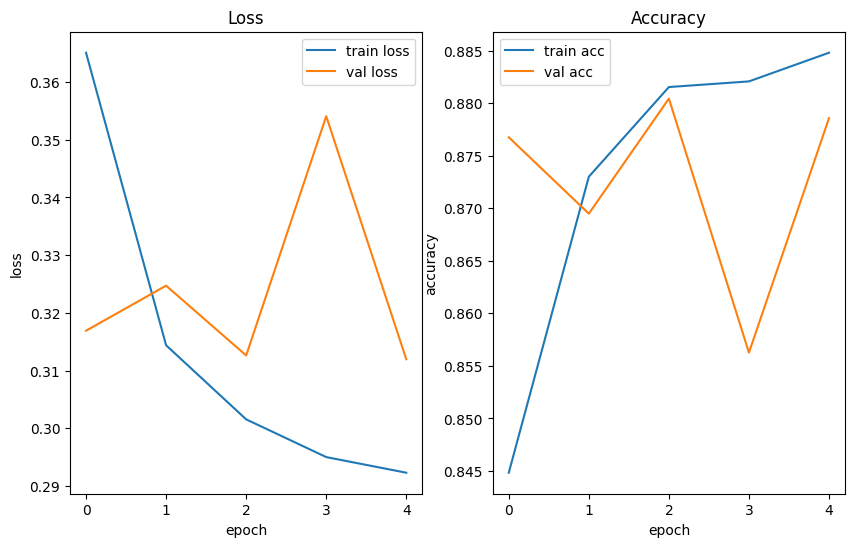

In [ ]:
plot_log('/content/drive/MyDrive/Colab Notebooks/hw3-handout/log/log6.csv', save_plot_path)

#### Setting7:
1.   Epoch: 10
2.   Batch size: 64
3.   Learning rate: 0.001
4.   Optimizer: Adam
5.   Weight decay = 1e-3
6.   Hidden layers: (64,32) (32,num_class)

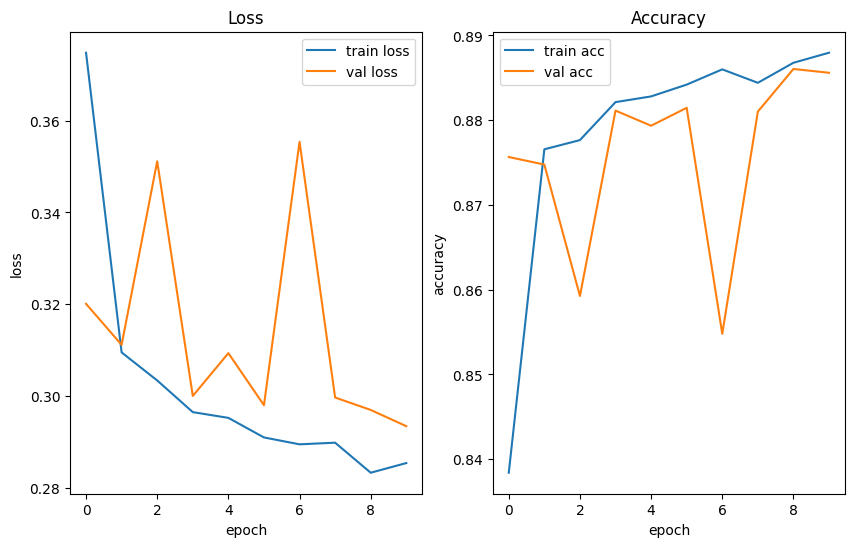

In [ ]:
plot_log('/content/drive/MyDrive/Colab Notebooks/hw3-handout/log/log7.csv', save_plot_path)

#### Setting8:
1.   Epoch: 10
2.   Batch size: 64
3.   Learning rate: 0.001
4.   Optimizer: SGD
5.   Weight decay = 1e-3
6.   Hidden layers: (64,32) (32,num_class)

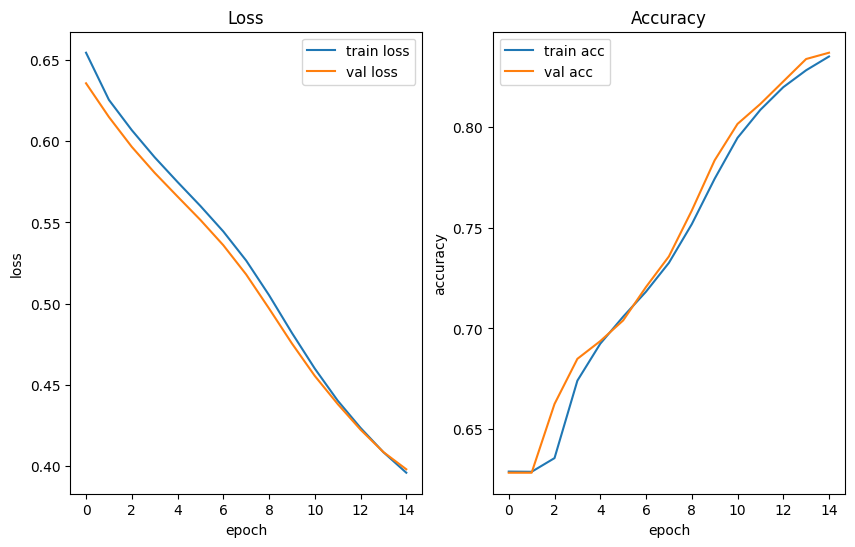

In [ ]:
plot_log('/content/drive/MyDrive/Colab Notebooks/hw3-handout/log/log8.csv', save_plot_path)

####

### Test on second-test-data-DIST.json file and generate the prediction line by line. Save the results in test-result.txt

In [ ]:
import json
def test(file, model, save_file):
  with open(file, 'r') as f:
    test_data = json.load(f)

  model = model.eval().to(device)
  predictions = []
  for items in test_data:
    inputs = tokenizer(items['text'], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
      logits = model(**inputs)
    prediction = logits.argmax(dim=1).item()

    predictions.append(prediction)

    with open(save_file, 'w') as f:
      for pred in predictions:
        f.write(f"{pred}\n")


In [ ]:
model = BertForTextClassification("bert-base-uncased", num_classes=2)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/hw3-handout/model/model5.pt"))

file = '/content/drive/MyDrive/Colab Notebooks/hw3-handout/second-test-data-DIST.json'
save_file = os.path.join('/content/drive/MyDrive/Colab Notebooks/hw3-handout','test-results.txt')

test(file, model, save_file)

<ipython-input-35-da427e56018a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/hw3-handout/model/m